In [1]:
import os
import numpy as np
import torch
import cv2
from torch.utils.data import DataLoader
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from collections import Counter
from scipy.signal import argrelextrema
from scipy.special import factorial
import itertools

# Get the path of the project root
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..', '..'))

# Add the project root to sys.path if it is not already in sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# Import the ImageSequenceDataset and create_dataloader from the pipeline module
from seismogram_extraction.pipeline import evaluate_filter, create_dataloader
from seismogram_extraction.filters.hungarian_kalman_filter import HungarianKalmanFilter

import torch.multiprocessing as mp
mp.set_start_method('spawn')  # or 'forkserver' if available

from collections import defaultdict

plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.titlesize'] = 20

# Load the seismogram

In [2]:
# Paths to your files
image_path = r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\raw\UCC19540112Gal_E_0750_binary.jpg"

# Load image as grayscale and convert to float32
image_source = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
image_source = image_source.astype(np.float32) / 255.0  # Normalize to [0, 1]
image_source = image_source.max() - image_source  # Invert the image

# crop
# image_source = image_source[:, 1000:2000]
image_source = image_source[775:1090, 1000:1400]

# Confirm shapes
print("Image shape:", image_source.shape)   # (height, width)

Image shape: (315, 400)


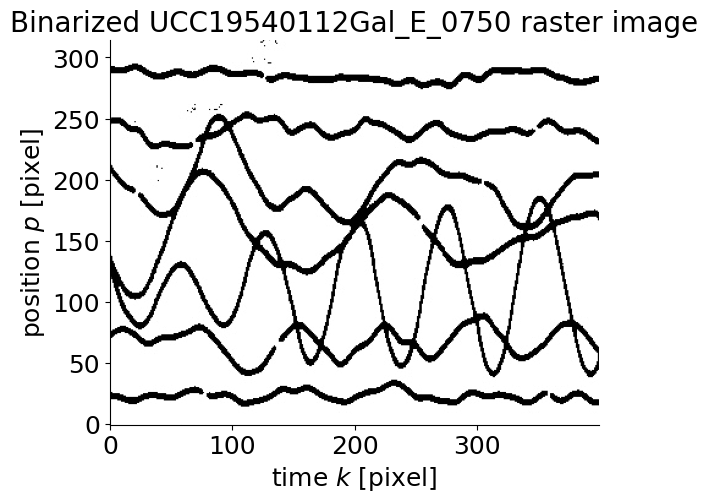

In [3]:
# First figure: imshow
plt.figure(figsize=(12, 5))
plt.imshow(image_source.max()-image_source, cmap='gray', origin='lower')
plt.xlabel(r"time $k$ [pixel]")
plt.ylabel(r"position $p$ [pixel]")
plt.title("Binarized UCC19540112Gal_E_0750 raster image")
plt.grid(False)

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"UCC19540112Gal_E_0750_binary.jpg"), bbox_inches='tight', dpi=300)
plt.show()

# Second figure: scatter-only pixel representation
# plt.figure(figsize=(12, 5))
# for k in range(len(gt[0])):
#     col = np.where(image[:, k] > 0.5)[0]
#     if len(col) > 0:
#         plt.scatter(k*np.ones_like(col), col, s=1, color='red', alpha=0.6)  
# plt.title("Pixel Discretization of Ground Truth Traces (scatter only)")
# plt.xlabel("k (time)")
# plt.ylabel("p (position)")
# plt.grid(True)
# plt.show()


## Get Region Of Interest

Threshold1: 123.62459373474121
Threshold2: 69.1062728881836


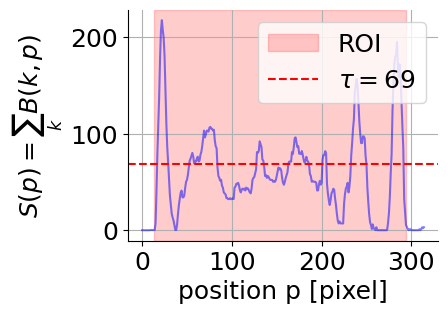

In [4]:
def get_roi(image, threshold = 100):
    """
    Extract the region of interest from an image based on row sum threshold.

    Parameters:
    - image (np.ndarray): 2D or 3D grayscale image array.
    - threshold (int): Minimum row sum to consider as part of the ROI.

    Returns:
    - roi (np.ndarray): Cropped image containing only the rows in the ROI.
    - start_row (int): Index of the first row included in the ROI.
    - end_row (int): Index of the last row (exclusive) in the ROI.
    """
    sum_rows = image.sum(axis=1)
    indices = np.where(sum_rows > threshold)[0]

    if len(indices) == 0:
        print("No rows exceed the threshold.")
        return image[0:1], 0, 1  # dummy ROI and bounds

    start_row = max(int(indices[0] - 0.01 * image.shape[0]), 0)
    end_row = min(int(indices[-1] + 0.01 * image.shape[0]), image.shape[0])

    roi = image[start_row:end_row]
    return roi, start_row, end_row

sum_rows = image_source.sum(axis=1)

plt.figure(figsize=(4, 3))
plt.plot(sum_rows, color='blue', alpha=0.5)
plt.xlabel("position p [pixel]")
plt.ylabel(r"$S(p) = \sum_k B(k, p)$")
plt.grid(True)

# Thresholds
k = 1.5
threshold1 = np.mean(sum_rows) + k * np.std(sum_rows)
print("Threshold1:", threshold1)

threshold2 = np.percentile(sum_rows, 65)
print("Threshold2:", threshold2)

# Get region of interest using one of the thresholds
image, start_row, end_row = get_roi(image_source, threshold=int(threshold2))

# Highlight ROI with vertical bars
plt.axvspan(start_row, end_row, color='red', alpha=0.2, label='ROI')
plt.axhline(y=threshold2, color='red', linestyle='--', label=r'$\tau = {}$'.format(int(threshold2)))
plt.legend()

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"get_roi.pdf"), format="pdf", bbox_inches='tight', dpi=300)

plt.show()

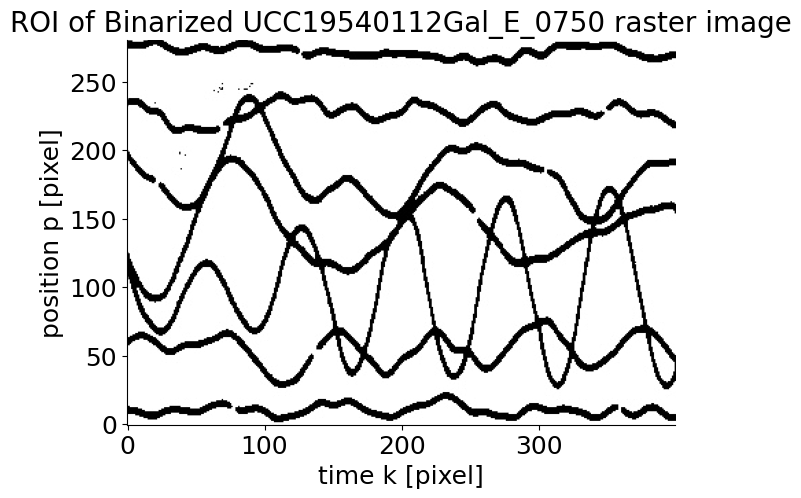

In [5]:
# First figure: imshow
plt.figure(figsize=(12, 5))
plt.imshow(image.max()-image, cmap='gray', origin='lower')
plt.xlabel("time k [pixel]")
plt.ylabel("position p [pixel]")
plt.title("ROI of Binarized UCC19540112Gal_E_0750 raster image")
plt.grid(False)

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"UCC19540112Gal_E_0750_binary_roi.jpg"), bbox_inches='tight', dpi=300)
plt.show()

# Get number of components and average thickness

In [6]:
def count_components_and_avg_thickness(arr, threshold=0.5):
    """
    Counts the number of connected components where values are close to 1 
    and computes the average thickness.

    Parameters:
    - arr: 1D numpy array containing binary values (0 for background, 1 for foreground).
    - threshold: Defines what is considered "foreground" (default: 0.5 for binary).

    Returns:
    - count: Number of connected components (foreground regions).
    - avg_thickness: Average thickness (length) of those components.
    """
    count = 0
    thicknesses = []
    n = len(arr)
    
    i = 0
    while i < n:
        if arr[i] > threshold:  # Found a new foreground component
            count += 1
            start = i
            while i < n and arr[i] > threshold:
                i += 1
            thicknesses.append(i - start)
        else:
            i += 1

    avg_thickness = np.mean(thicknesses) if thicknesses else 0
    return count, avg_thickness

# apply to the columns of the image and compute the average thickness, average number of components
N_components = []
thickness = []

for i in range(image.shape[1]):
    n, t = count_components_and_avg_thickness(image[:, i])
    N_components.append(n)
    thickness.append(t)

# compute the average thickness and number of components for the image by ignoring the columns with no components
N_components = np.array(N_components)
thickness = np.array(thickness)
N_components = N_components[N_components > 0.9]
thickness = thickness[thickness > 0.9]

def most_common_component_count(N_components):
    """
    Returns the most frequently occurring value in the list of component counts.
    If there's a tie, returns the smallest one.
    """
    counter = Counter(N_components)
    print(counter)
    most_common = counter.most_common(1)[0][0]  # (value, frequency)
    return most_common

# Example usage
most_N_components = most_common_component_count(N_components)
print("Most common component count:", most_N_components)

median_N_components = int(np.round(np.median(N_components)))
print(f"Median number of components: {median_N_components}")
avg_N_components = int(np.round(np.mean(N_components)))
avg_thickness = int(np.round(np.mean(thickness)))
print(f"Average number of components: {avg_N_components} VS true value is 7")
print(f"Average thickness: {avg_thickness}")

Counter({7: 245, 6: 123, 5: 20, 8: 12})
Most common component count: 7
Median number of components: 7
Average number of components: 7 VS true value is 7
Average thickness: 7


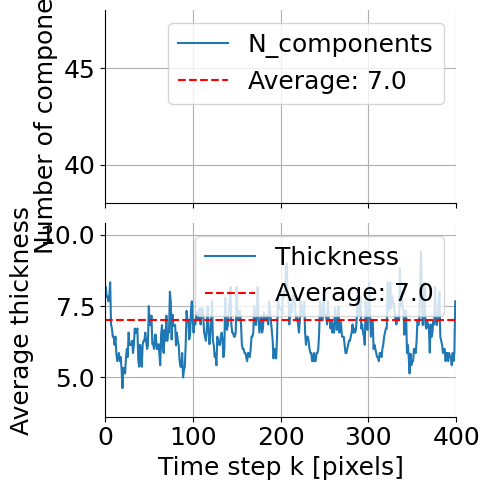

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5), sharex=True)

# --- Top subplot: Number of components ---
ax1.plot(N_components, label="N_components")
ax1.axhline(y=avg_N_components, color='r', linestyle='--', label=f"Average: {avg_N_components:.1f}")
ax1.set_xlim(0, image.shape[1])
ax1.set_ylim(38, 48)
ax1.set_ylabel("Number of components")
ax1.legend()
ax1.grid(True)

# --- Bottom subplot: Average thickness ---
ax2.plot(thickness, label="Thickness")
ax2.axhline(y=avg_thickness, color='r', linestyle='--', label=f"Average: {avg_thickness:.1f}")
ax2.set_xlim(0, image.shape[1])
ax2.set_ylim(np.min(thickness)-1, np.max(thickness)+1)
ax2.set_xlabel("Time step k [pixels]")
ax2.set_ylabel("Average thickness")
ax2.legend()
ax2.grid(True)

# Tight layout for aesthetics
plt.tight_layout()

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"N_com_thickness.pdf"), format="pdf", bbox_inches='tight', dpi=300)
plt.show()

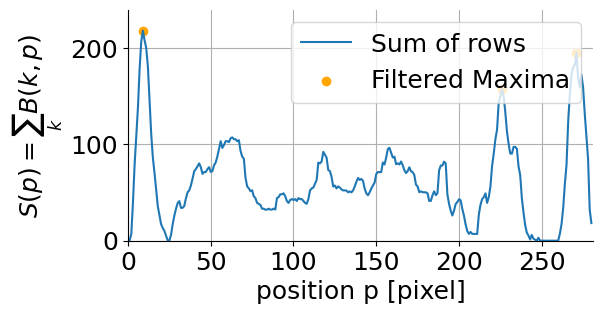

[  9 226 271]
Filtered array: [217  45]
Mean without outliers: 132


In [8]:

# Step 1: Sum the rows
sum_rows = np.sum(image, axis=1)
plt

# Step 2: Find local maxima
max_indices = argrelextrema(sum_rows, np.greater, order=10)[0]

# Step 3: Sort maxima by peak height (descending)
sorted_max = max_indices[np.argsort(sum_rows[max_indices])[::-1]]

# Step 4: Keep only top N
top_max = sorted_max[:avg_N_components]

# Step 5: Filter out those lower than half the max peak value
peak_values = sum_rows[top_max]
max_peak_value = np.max(peak_values)
threshold_value = 0.5 * max_peak_value

filtered_max = top_max[peak_values >= threshold_value]

# Step 6: Plot
plt.figure(figsize=(6, 3))
plt.plot(sum_rows, label="Sum of rows")
plt.scatter(filtered_max, sum_rows[filtered_max], color='orange', label="Filtered Maxima")
plt.xlim(0, image.shape[0])
plt.ylim(0, np.max(sum_rows) + 0.1 * np.max(sum_rows))
plt.xlabel("position p [pixel]")
plt.ylabel(r"$S(p) = \sum_k B(k, p)$")
plt.grid(True)

plt.legend()

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"filtered_max.pdf"), format="pdf", bbox_inches='tight', dpi=300)
plt.show()
# print sorted filtered max
print(np.sort(filtered_max))
arr = np.diff(np.sort(filtered_max))

# Compute IQR bounds
q1 = np.percentile(arr, 25)
q3 = np.percentile(arr, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
filtered = arr[(arr >= lower_bound) & (arr <= upper_bound)]

# Compute the mean
mean_val = np.mean(filtered)

print("Filtered array:", filtered)
print("Mean without outliers:", int(1+np.round(mean_val)))

Average spacing between meanlines: 131.0


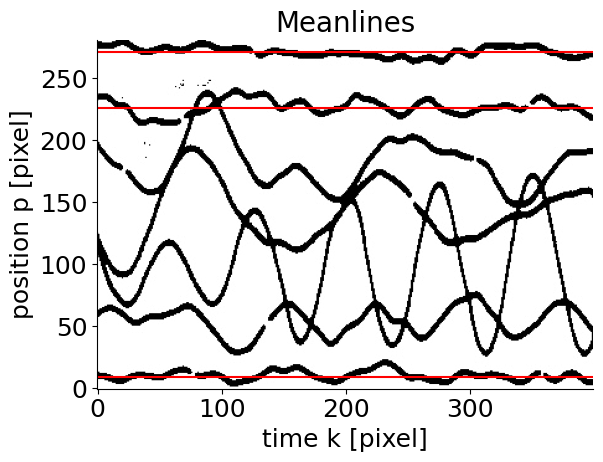

In [9]:
# The meanlines are the num_components rows with the minimum sum

def mean_ignoring_outliers_std(arr, k=2):
    arr = np.array(arr)
    mean = np.mean(arr)
    std = np.std(arr)
    filtered = arr[np.abs(arr - mean) <= k * std]
    return np.mean(filtered)

meanlines = np.sort(filtered_max[:avg_N_components])
spaces = np.diff(meanlines)
spacing = mean_ignoring_outliers_std(spaces, k=1.5)

print("Average spacing between meanlines:", spacing)

plt.imshow(image.max() - image, cmap='gray', origin='lower')
for meanline in meanlines:
    plt.axhline(meanline, color='r')
plt.title("Meanlines")
plt.xlabel("time k [pixel]")
plt.ylabel("position p [pixel]")
plt.grid(False)

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"UCC19540112Gal_E_0750_meanlines.jpg"), bbox_inches='tight', dpi=300)
plt.show()

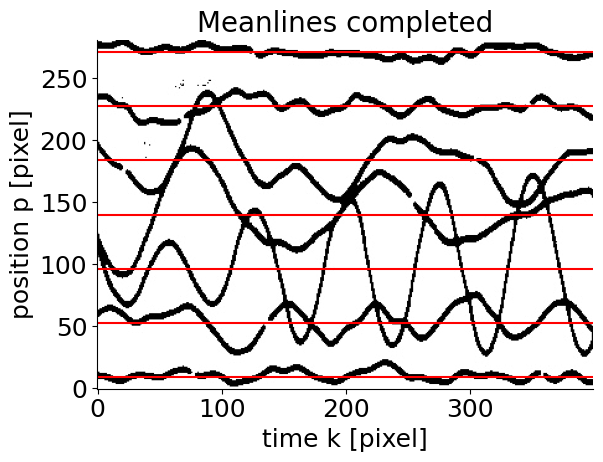

In [10]:
meanlines = np.linspace(meanlines[0], meanlines[-1], avg_N_components)

plt.imshow(image.max() - image, cmap='gray', origin='lower')
for meanline in meanlines:
    plt.axhline(meanline, color='r')
plt.title("Meanlines completed")
plt.xlabel("time k [pixel]")
plt.ylabel("position p [pixel]")
plt.grid(False)

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"UCC19540112Gal_E_0750_all_meanlines.jpg"), bbox_inches='tight', dpi=300)
plt.show()

# Extract the curves ($\omega$ constant)

In [11]:
def build_A_matrix(Dt, order):
    """Build state transition matrix A for a constant-jerk-like model of given order."""
    A = np.zeros((order, order), dtype=np.float64)
    for i in range(order):
        for j in range(i, order):
            A[i, j] = Dt**(j - i) / factorial(j - i)
    return A

def build_Q_matrix(dt, q, order):
    """Build process noise covariance matrix Q with reversed order (low-order terms in bottom-right)."""
    G = (dt ** np.arange(1, order + 1) / factorial(np.arange(1, order + 1)))[::-1].reshape(-1, 1)  # reverse and column
    Q = q**2 * (G @ G.T)
    return Q


def build_P_matrix(order, P_0_vector):
    """Build initial state covariance matrix P with increasing uncertainty."""
    P = np.zeros((order, order), dtype=np.float64)
    for i in range(order):
        P[i, i] = P_0_vector[i] 
    return P

In [12]:
order = 4

P_0_vector = np.array([1, 10, 10, 10])

Dt_list = [0.2] 
q_list = [1.5, 3]
sigma_z_list = [4, 10]

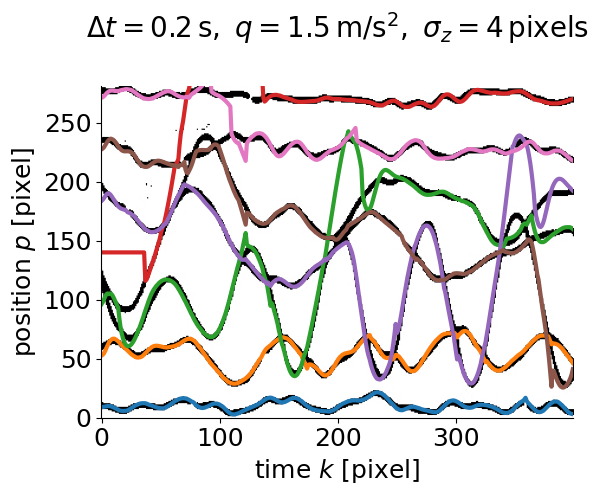

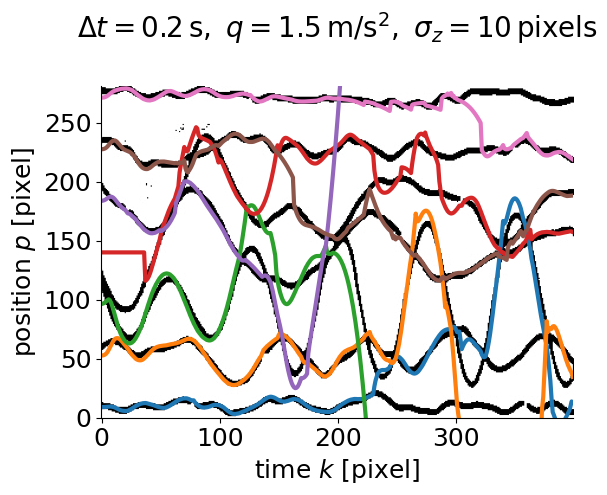

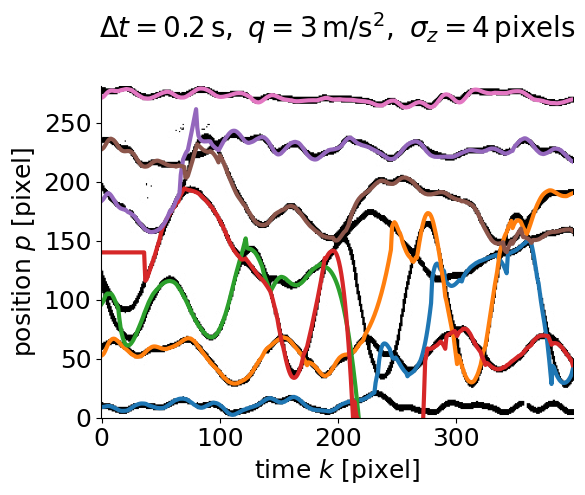

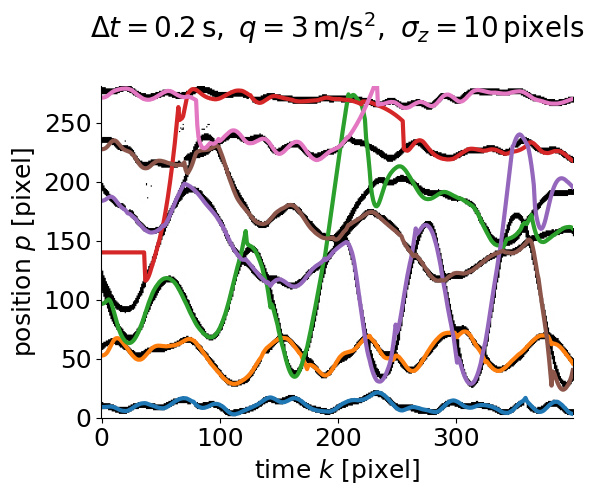

In [16]:
param_combinations = itertools.product(
        Dt_list, q_list, sigma_z_list
    )

# Loop through a small number for illustration (adjust as needed)
for idx, (Dt, q, sigma_z) in enumerate(param_combinations):
    A = build_A_matrix(Dt, order)
    Q = build_Q_matrix(Dt, q, order)
    P_0 = build_P_matrix(order, P_0_vector)
    P_0_extended = np.tile(P_0, (1, avg_N_components, 1, 1))
    H = np.zeros((1, order), dtype=np.float64)
    H[0, 0] = 1
    R = np.array([[sigma_z**2]], dtype=np.float64)
    HKF = HungarianKalmanFilter(A, H, Q, R)

    # X_0 = np.zeros((avg_N_components, Q.shape[-1]))
    # X_0[:, 0] = meanlines

    X_0 = np.zeros((1, avg_N_components, order))
    X_0[:, :, 0] = meanlines
    # print(X_0)
    X_batch_pred, P_batch_pred = HKF.process_sequence(image[np.newaxis][np.newaxis], X_0, P_0_extended, step=1)

    pred_positions = X_batch_pred[:, :, :, 0]

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot image
    ax.imshow(image.max() - image, cmap='gray', origin='lower')

    # Plot predicted positions
    t_steps = np.arange(0, image.shape[-1])
    for j in range(pred_positions.shape[2]):
        ax.plot(t_steps, pred_positions[0, :, j], linewidth=3)

    # Axis labels and title
    ax.set_xlabel("time $k$ [pixel]")
    ax.set_ylabel("position $p$ [pixel]")
    ax.grid(False)
    ax.set_ylim(0, image.shape[0])

    # Title using fig.suptitle
    fig.suptitle(rf"$\Delta t={Dt}\, \mathrm{{s}},\ q={q}\, \mathrm{{m/s^2}},\ \sigma_z={sigma_z}\, \mathrm{{pixels}}$", fontsize=20)

    # Layout and save
    fig.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle

    # Save figure before closing
    filepath = f"output/seismograms/Dt_{Dt}_q_{q}_sigma_z_{sigma_z}.pdf"
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    fig.savefig(filepath, bbox_inches='tight', dpi=300, format="pdf")
    plt.show()
    # Close to free memory
    plt.close(fig)
# fig.tight_layout()
# # Ensure the output folder exists
# output_folder_path = os.path.join(os.getcwd(), "output")
# os.makedirs(output_folder_path, exist_ok=True)

# # Save the figure
# fig.savefig(os.path.join(output_folder_path, f"UCC19540112Gal_E_0750_processed_w_cst.jpg"), bbox_inches='tight', dpi=300)

# T = pred_positions.shape[0]
# t = np.arange(T)
# fig, axes = plt.subplots(2, 1, figsize=(24, 10), sharex=True)

# labels = [r'$\dot{p}$', r'$\omega$']

# for l in range(2):
#     for j in range(avg_N_components):
#         pred = X_batch_pred[0, :, :, l+1]
#         std_pred = np.sqrt(P_batch_pred[0, :, :, l+1, l+1])

#         axes[l].plot(t, pred[:, j], label=f'Trace {j+1}')
#         axes[l].fill_between(t,
#                             pred[:, j] - std_pred[:, j],
#                             pred[:, j] + std_pred[:, j],
#                             alpha=0.3)

#     axes[l].set_xlim(0, T)
#     # axes[l].legend(markerscale=5)
#     axes[l].set_ylabel(labels[l])
# axes[-1].set_xlabel('Time step')